# Participant report

This section aims at analyzing the specificity of the app through the aalysis of the DDLD samples 

1) We train the model using NT toddlers and ASD toddlers. 
2) We see whether the DDLD are classified among the NT or ASD groups.

3) We train the model with ASD and non-ASD
4) We see whether the app is able to classify between both

In 1) and 2), what are learned are the autistic and nt regions of a high dimensional space that distinguishes both groups, and the goal is to assess whether the ddld fall into the asd or nt parts. If they mostly fall into the NT category, then it would mean that the app have large specificity, ie the app features are distinguishing well asd vs non asd, which is specificity to autism screening. 

In 3) and 4), If the performances of the asd screening decreases, compared to training with only ASD, it seems to mean that the ASD and DDLD are somehow close and so the app specificity to DDLD is lower. 

It might be that only one of the two scenario might be necessary to assess the specificity of the app, but let's see. Guillermo proposed to analyze the performances on ASD+DDLD and separately. I think this means to do:

1) Train NT vs ASD+DDLD and see the performances: this analyze the ability of the app to screen for developmental concerns. 
2) Train NT vs DDLD and see ability to screen for DDLD
3) See if adding the DDLD to NT when training increases ASD screening perfromances. 


2) We can also try multi-class classification to see whether we can actually distinguis the three! 


TODO: We can try to see chich features elpe the most to discriminate NT from DDLD

In [34]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# Compute Qulity Score for a scenario

**Compute compliance score to weight the samples**

In [36]:
features_importance_present_n = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'features_importance_present_n.npy'))

**Load the data and compute conidence score of the features**

In [51]:
xgboost_hyperparameters = {'scale_pos_weight':False,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 100,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}  
df =  pd.read_csv(AUTISM_DATA_PATH)

scenario = 'multimodal_2023_regular_ddld'

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = scenario, 
               positive_class = [2],
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=2, 
               proportion_train=1)

conf_values = np.zeros((data.num_samples, len(DEFAULT_PREDICTORS)))

for i, feat in enumerate(DEFAULT_PREDICTORS):
    
    if feat in TOUCH_VARIABLES:
        
        # These features don't depend on the number of touches, it is a value that we measures and so its confidence should be 1. 
        # We weight only the features that depend on the number of features.
        if feat in ['number_of_touches', 'number_of_target']:
            
            conf_values[:, i] = (~np.isnan(data._X_train[:,i])).astype(int)
        
        else:
            
            conf_values[:, i] = (~np.isnan(data._X_train[:,i])).astype(int) * data.df['touch_conf']
        
    elif feat == 'proportion_of_name_call_responses':
        
        conf_values[:, i] = data.df['RTN_conf']
        
    elif feat == 'average_response_to_name_delay':
        
        # 0 if the delay is missing, the proportion of valid  name calls otherwise
        
        conf_values[:, i] = (~np.isnan(data._X_train[:,i])).astype(int) * data.df['RTN_conf']
            
    else:
        conf_values[:, i] = data.df['{}_conf'.format(feat)]
    
    
weighted_confidence_score = np.multiply(conf_values[:,:len(features_importance_present_n)], features_importance_present_n).sum(axis=1)
print(weighted_confidence_score.shape)
np.save(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_{}.npy'.format(scenario)), weighted_confidence_score)


Post-processing inital df (removing columns with no cva features, encoding srings, compute administrations order, compute condensed S/NS variables)... 
Removing 2019/2817 keeping only subject in studies: ['ARC', 'P1', 'P2', 'P3'].
Removing 9/798 incomplete administrations.
Removing 128/789 keeping first admin.
Removing 54/661 keeping only subject with diagnosis: [0, 1, 2].
Removing 132/607 keeping only subject with age between 17 and 37 mo.
475 administrations left.


,id
diagnosis,
0.0,328
1.0,49
2.0,98


Predicting diagnosis based on 21 features
Splitting dataset into test and train set.
(475,)


In [53]:
exp

49

In [48]:
np.quantile(weighted_confidence_score, [0.25, 0.5, 0.75])

array([0.87583575, 0.92636503, 0.98036401])

In [66]:
idx_nt = np.array(data.df[data.df['diagnosis'] == 0].index)
idx_asd = np.array(data.df[data.df['diagnosis'] == 1].index)
idx_ddld = np.array(data.df[data.df['diagnosis'] == 2].index)

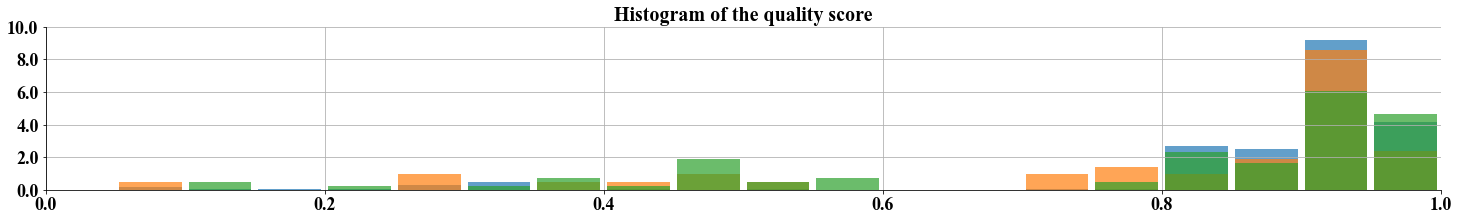

In [72]:
csfont = {'fontname':'Times New Roman'}
#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold', fontsize=20, **csfont)
plt.hist(weighted_confidence_score[idx_nt], density=True, color='tab:blue', alpha=.7, bins=np.arange(0, 1.05, 0.05), rwidth=.9)
plt.hist(weighted_confidence_score[idx_asd], density=True,color='tab:orange', alpha=.7, bins=np.arange(0, 1.05, 0.05), rwidth=.9)
plt.hist(weighted_confidence_score[idx_ddld],density=True, color='tab:green', alpha=.7, bins=np.arange(0, 1.05, 0.05), rwidth=.9)

#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.xlim([0, 1])
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.grid()
#plt.savefig(os.path.join(ROOT_DIR, 'figures', 'compliance_score_hist.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')
None

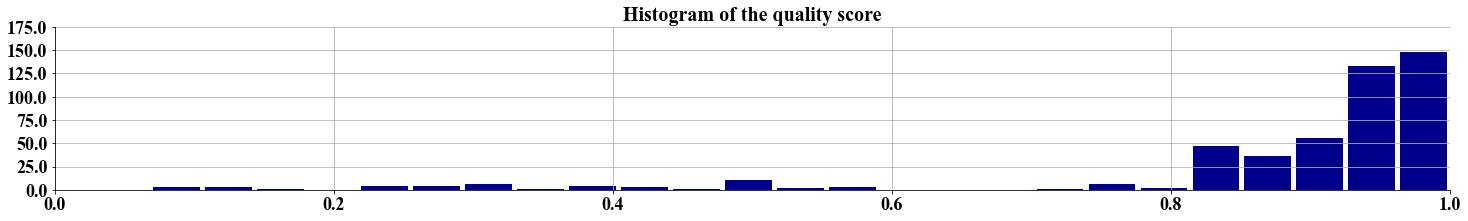

In [43]:
csfont = {'fontname':'Times New Roman'}
#weighted_confidence_score = np.multiply(conf_values, general_shap_values_normalized).sum(axis=1)
fi(25, 3)
plt.title("Histogram of the quality score", weight='bold', fontsize=20, **csfont)
plt.hist(weighted_confidence_score.flatten(), color='darkblue', bins=25, rwidth=.9)

#plt.xticks(ticks = np.arange(features_importances_extended.shape[0]), labels=[feature_name_mapping[f] for f in np.array(labels)[idx_sorting]], rotation =90)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.xlim([0, 1])
plt.gca().set_yticks(plt.gca().get_yticks(), np.round(plt.gca().get_yticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.gca().set_xticks(plt.gca().get_xticks(), np.round(plt.gca().get_xticks(), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.grid()
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'compliance_score_hist.png'), dpi=200, bbox_inches = 'tight', facecolor=plt.gcf().get_facecolor(), edgecolor='none')
None

# Experiemnt NT vs DDLD

In [3]:
scenario = 'multimodal_2023_regular_ddld_only'


use_weight = True
if use_weight:
    
    df =  pd.read_csv(AUTISM_DATA_PATH)

    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_{}.npy'.format(scenario)))
else:
    weighted_confidence_score = None
    
    
K = 50

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = scenario,
                   positive_class = [2],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='21_December_Final_With_Weight_ddld_nt', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=random_state)
    display(exp.performances_df)
    

Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 1!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,0,0.487,0.367,-0.011,0.171,0.909,0.601,0.045,0.601,0.105,0.232,-0.044,0.98,0.009,0.228,0.022,0.6,0.02,0.772,0.4,96,3,325,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 2!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,1,0.498,0.364,0.023,0.184,0.903,0.599,0.044,0.599,0.104,0.228,-0.089,0.99,0.0,0.228,0.023,0.0,0.01,0.772,1.0,97,0,328,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 3!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,2,0.477,0.358,-0.012,0.171,0.903,0.6,0.045,0.6,0.104,0.23,-0.044,0.99,0.003,0.229,0.023,0.5,0.01,0.771,0.5,97,1,327,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 4!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,3,0.521,0.368,0.065,0.17,0.906,0.599,0.044,0.599,0.104,0.228,-0.089,0.99,0.0,0.228,0.023,0.0,0.01,0.772,1.0,97,0,328,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 5!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,4,0.465,0.35,0.024,0.123,0.901,0.6,0.045,0.6,0.105,0.232,-0.021,0.99,0.006,0.229,0.023,0.667,0.01,0.771,0.333,97,2,326,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 6!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,5,0.528,0.372,0.124,0.157,0.912,0.602,0.045,0.602,0.105,0.237,0.008,0.99,0.012,0.23,0.023,0.8,0.01,0.77,0.2,97,4,324,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 7!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,6,0.513,0.375,0.109,0.176,0.916,0.6,0.045,0.6,0.104,0.228,-0.087,0.98,0.003,0.227,0.022,0.333,0.02,0.773,0.667,96,1,327,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 8!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,7,0.523,0.365,0.129,0.16,0.904,0.605,0.046,0.605,0.106,0.246,0.042,0.99,0.024,0.233,0.023,0.889,0.01,0.767,0.111,97,8,320,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 9!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,8,0.518,0.374,0.07,0.14,0.913,0.599,0.044,0.599,0.104,0.225,-0.126,0.98,0.0,0.226,0.022,0.0,0.02,0.774,1.0,96,0,328,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 10!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,9,0.482,0.352,0.042,0.155,0.897,0.599,0.044,0.599,0.104,0.225,-0.126,0.98,0.0,0.226,0.022,0.0,0.02,0.774,1.0,96,0,328,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 11!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,10,0.521,0.363,0.195,0.085,0.869,0.6,0.045,0.6,0.105,0.23,-0.062,0.98,0.006,0.227,0.022,0.5,0.02,0.773,0.5,96,2,326,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 12!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,11,0.49,0.36,0.064,0.161,0.906,0.604,0.045,0.604,0.106,0.244,0.035,0.99,0.021,0.232,0.023,0.875,0.01,0.768,0.125,97,7,321,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 13!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,12,0.512,0.374,0.04,0.183,0.908,0.599,0.044,0.599,0.104,0.225,-0.126,0.98,0.0,0.226,0.022,0.0,0.02,0.774,1.0,96,0,328,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 14!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,13,0.476,0.34,-0.089,0.145,0.884,0.601,0.045,0.601,0.105,0.228,-0.105,0.959,0.009,0.224,0.022,0.429,0.041,0.776,0.571,94,3,325,4


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 15!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,14,0.499,0.357,0.048,0.117,0.898,0.605,0.046,0.605,0.106,0.246,0.042,0.99,0.024,0.233,0.023,0.889,0.01,0.767,0.111,97,8,320,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 16!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,15,0.511,0.382,0.154,0.159,0.922,0.6,0.045,0.6,0.105,0.232,-0.021,0.99,0.006,0.229,0.023,0.667,0.01,0.771,0.333,97,2,326,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 17!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,16,0.519,0.372,0.051,0.165,0.912,0.6,0.045,0.6,0.105,0.232,-0.021,0.99,0.006,0.229,0.023,0.667,0.01,0.771,0.333,97,2,326,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 18!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,17,0.485,0.359,0.024,0.171,0.903,0.599,0.044,0.599,0.104,0.225,-0.126,0.98,0.0,0.226,0.022,0.0,0.02,0.774,1.0,96,0,328,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 19!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,18,0.489,0.36,0.056,0.153,0.907,0.599,0.044,0.599,0.104,0.225,-0.126,0.98,0.0,0.226,0.022,0.0,0.02,0.774,1.0,96,0,328,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 20!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,19,0.528,0.364,0.162,0.146,0.908,0.599,0.044,0.599,0.104,0.228,-0.089,0.99,0.0,0.228,0.023,0.0,0.01,0.772,1.0,97,0,328,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 21!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,20,0.462,0.335,-0.073,0.121,0.883,0.6,0.045,0.6,0.104,0.225,-0.12,0.969,0.003,0.225,0.022,0.25,0.031,0.775,0.75,95,1,327,3


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 22!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,21,0.493,0.351,-0.032,0.128,0.896,0.599,0.044,0.599,0.104,0.225,-0.126,0.98,0.0,0.226,0.022,0.0,0.02,0.774,1.0,96,0,328,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 23!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,22,0.488,0.346,0.028,0.116,0.892,0.6,0.045,0.6,0.104,0.225,-0.12,0.969,0.003,0.225,0.022,0.25,0.031,0.775,0.75,95,1,327,3


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 24!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,23,0.454,0.346,-0.001,0.126,0.898,0.6,0.045,0.6,0.104,0.23,-0.044,0.99,0.003,0.229,0.023,0.5,0.01,0.771,0.5,97,1,327,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 25!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,24,0.511,0.367,0.1,0.165,0.909,0.599,0.044,0.599,0.104,0.225,-0.126,0.98,0.0,0.226,0.022,0.0,0.02,0.774,1.0,96,0,328,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 26!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,25,0.497,0.356,0.058,0.138,0.899,0.599,0.044,0.599,0.104,0.228,-0.089,0.99,0.0,0.228,0.023,0.0,0.01,0.772,1.0,97,0,328,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 27!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,26,0.506,0.378,0.152,0.161,0.921,0.599,0.044,0.599,0.104,0.228,-0.089,0.99,0.0,0.228,0.023,0.0,0.01,0.772,1.0,97,0,328,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 28!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,27,0.482,0.351,0.04,0.117,0.899,0.599,0.044,0.599,0.104,0.228,-0.089,0.99,0.0,0.228,0.023,0.0,0.01,0.772,1.0,97,0,328,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 29!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,28,0.5,0.369,0.023,0.175,0.909,0.599,0.044,0.599,0.104,0.228,-0.089,0.99,0.0,0.228,0.023,0.0,0.01,0.772,1.0,97,0,328,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 30!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,29,0.488,0.371,0.033,0.173,NaN,0.603,0.045,0.603,0.106,0.237,-0.017,0.98,0.015,0.229,0.023,0.714,0.02,0.771,0.286,96,5,323,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 31!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,30,0.487,0.362,-0.017,0.152,0.903,0.6,0.045,0.6,0.104,0.225,-0.12,0.969,0.003,0.225,0.022,0.25,0.031,0.775,0.75,95,1,327,3


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 32!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,31,0.506,0.376,0.084,0.169,0.918,0.599,0.044,0.599,0.104,0.228,-0.089,0.99,0.0,0.228,0.023,0.0,0.01,0.772,1.0,97,0,328,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 33!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,32,0.497,0.358,-0.056,0.161,0.898,0.6,0.045,0.6,0.104,0.223,-0.148,0.959,0.003,0.223,0.022,0.2,0.041,0.777,0.8,94,1,327,4


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 34!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,33,0.527,0.369,0.227,0.144,0.914,0.6,0.045,0.6,0.104,0.218,-0.193,0.939,0.003,0.22,0.021,0.143,0.061,0.78,0.857,92,1,327,6


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 35!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,34,0.497,0.342,-0.02,0.094,0.861,0.6,0.045,0.6,0.104,0.23,-0.044,0.99,0.003,0.229,0.023,0.5,0.01,0.771,0.5,97,1,327,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 36!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,35,0.495,0.365,0.016,0.166,0.906,0.609,0.046,0.609,0.108,0.258,0.069,0.99,0.04,0.235,0.023,0.929,0.01,0.765,0.071,97,13,315,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 37!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,36,0.498,0.363,0.066,0.162,0.909,0.602,0.045,0.602,0.105,0.232,-0.061,0.969,0.012,0.227,0.022,0.571,0.031,0.773,0.429,95,4,324,3


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 38!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,37,0.511,0.373,0.169,0.133,0.918,0.6,0.045,0.6,0.104,0.228,-0.087,0.98,0.003,0.227,0.022,0.333,0.02,0.773,0.667,96,1,327,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 39!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,38,0.488,0.36,-0.03,0.167,0.899,0.599,0.044,0.599,0.104,0.221,-0.178,0.959,0.0,0.223,0.022,0.0,0.041,0.777,1.0,94,0,328,4


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 40!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,39,0.527,0.386,0.145,0.196,0.921,0.6,0.045,0.6,0.104,0.225,-0.12,0.969,0.003,0.225,0.022,0.25,0.031,0.775,0.75,95,1,327,3


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 41!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,40,0.503,0.368,0.026,0.153,0.91,0.6,0.045,0.6,0.105,0.232,-0.021,0.99,0.006,0.229,0.023,0.667,0.01,0.771,0.333,97,2,326,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 42!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,41,0.496,0.357,-0.068,0.17,0.894,0.6,0.045,0.6,0.104,0.23,-0.044,0.99,0.003,0.229,0.023,0.5,0.01,0.771,0.5,97,1,327,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 43!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,42,0.527,0.386,0.145,0.196,0.921,0.6,0.045,0.6,0.104,0.225,-0.12,0.969,0.003,0.225,0.022,0.25,0.031,0.775,0.75,95,1,327,3


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 44!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,43,0.489,0.347,-0.003,0.105,0.881,0.6,0.045,0.6,0.104,0.228,-0.087,0.98,0.003,0.227,0.022,0.333,0.02,0.773,0.667,96,1,327,2


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 45!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,44,0.487,0.36,0.032,0.139,0.905,0.599,0.044,0.599,0.104,0.223,-0.154,0.969,0.0,0.225,0.022,0.0,0.031,0.775,1.0,95,0,328,3


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 46!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,45,0.517,0.351,0.137,0.126,0.897,0.6,0.045,0.6,0.105,0.232,-0.021,0.99,0.006,0.229,0.023,0.667,0.01,0.771,0.333,97,2,326,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 47!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,46,0.474,0.356,0.02,0.138,0.906,0.6,0.045,0.6,0.104,0.23,-0.044,0.99,0.003,0.229,0.023,0.5,0.01,0.771,0.5,97,1,327,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 48!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,47,0.528,0.372,0.124,0.157,0.912,0.602,0.045,0.602,0.105,0.237,0.008,0.99,0.012,0.23,0.023,0.8,0.01,0.77,0.2,97,4,324,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 49!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,48,0.516,0.368,0.141,0.16,0.91,0.6,0.045,0.6,0.104,0.23,-0.044,0.99,0.003,0.229,0.023,0.5,0.01,0.771,0.5,97,1,327,1


Saving experiment in folder 21_December_Final_With_Weight_ddld_nt.
Doing experiment 50!


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,49,0.489,0.369,0.01,0.186,0.909,0.6,0.045,0.6,0.105,0.23,-0.062,0.98,0.006,0.227,0.022,0.5,0.02,0.773,0.5,96,2,326,2


**Analysis**

In [9]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['21_December_Final_With_Weight_ddld_nt'])#'13_november_bis'])#'November 2022'])
pi = df.iloc[0]['y_true'][0].mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
df['NPV Corr'] = df.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)


100%|██████████| 51/51 [00:15<00:00,  3.38it/s]


In [13]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'optimal_threshold'])

metrics_of_interest = ['AUROC', 'Sensitivity', 'Specificity','PPV', 'PPV-Corr', 'NPV', 'NPV Corr', 'TP', 'TN', 'FP', 'FN']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV','PPV-Corr', 'NPV', 'NPV Corr']#, 'Precision Corrected']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV', 'NPV']#, 'Precision Corrected']


for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                       'optimal_threshold': experiment_row['optimal_threshold']
                                                                      }, ignore_index=True)
        

In [18]:
results_df_vertical.groupby(['metric_name']).describe()['score']

,count,mean,std,min,25%,50%,75%,max
metric_name,,,,,,,,
AUROC,50.0,0.49964,0.018570,0.454,0.488,0.497500,0.515250,0.528000
FN,50.0,1.84000,1.094700,1.000,1.000,1.500000,2.000000,6.000000
FP,50.0,326.22000,2.565787,315.000,326.000,327.000000,328.000000,328.000000
NPV,50.0,0.34846,0.310629,0.000,0.000,0.333000,0.592750,0.929000
NPV Corr,50.0,0.60051,0.439776,0.000,0.000,0.865298,0.949213,0.994048
PPV,50.0,0.22754,0.002644,0.220,0.226,0.228000,0.229000,0.235000
PPV-Corr,50.0,0.02250,0.000544,0.021,0.022,0.023000,0.023000,0.023000
Sensitivity,50.0,0.98138,0.011299,0.939,0.980,0.985000,0.990000,0.990000
Specificity,50.0,0.00536,0.007787,0.000,0.000,0.003000,0.006000,0.040000


In [24]:
df.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_ddld_nt.csv', index=False)

# ASD+DD/LD vs NT

In [ ]:
scenario = 'multimodal_2023_regular_ddld'


use_weight = True
if use_weight:
    
    df =  pd.read_csv(AUTISM_DATA_PATH)

    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_{}.npy'.format(scenario)))
else:
    weighted_confidence_score = None
    
    
K = 50

random_states = np.random.randint(0, 1000, K)

for i, random_state in enumerate(random_states):

    df =  pd.read_csv(AUTISM_DATA_PATH)

    data = Dataset(df=df, 
                   missing_data_handling='imputation',
                   imputation_method='constant',
                   sampling_method='without',
                   scenario = scenario,
                   positive_class = [1, 2],
                   features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
                   scale_data=False, 
                   use_missing_indicator_variables=False,
                   verbosity=1, 
                   proportion_train=1)

    exp = Experiments(data.dataset_name,
                      dataset=data, 
                      approach='xgboost', 
                      previous_experiment=None,        
                      debug=False, 
                      experiment_folder_name='21_December_Final_With_Weight_ddld+asd_nt', 
                      model_hyperparameters=xgboost_hyperparameters,
                      experiment_name = i, 
                      verbosity=1, 
                      save_experiment=True)

    exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score, random_state=random_state)
    display(exp.performances_df)
    

**Analysis**

In [28]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['21_December_Final_With_Weight_ddld+asd_nt'])#'13_november_bis'])#'November 2022'])
pi = df.iloc[0]['y_true'][0].mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
df['NPV Corr'] = df.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)


100%|██████████| 51/51 [00:15<00:00,  3.24it/s]


In [29]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'optimal_threshold'])

metrics_of_interest = ['AUROC', 'Sensitivity', 'Specificity','PPV', 'PPV-Corr', 'NPV', 'NPV Corr', 'TP', 'TN', 'FP', 'FN']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV','PPV-Corr', 'NPV', 'NPV Corr']#, 'Precision Corrected']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV', 'NPV']#, 'Precision Corrected']


for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                       'optimal_threshold': experiment_row['optimal_threshold']
                                                                      }, ignore_index=True)
        

In [30]:
results_df_vertical.groupby(['metric_name']).describe()['score']

,count,mean,std,min,25%,50%,75%,max
metric_name,,,,,,,,
AUROC,50.0,0.602880,0.013318,0.581,0.595,0.5995,0.611750,0.643000
FN,50.0,2.260000,1.208980,1.000,1.000,2.0000,3.000000,5.000000
FP,50.0,327.260000,2.048494,318.000,327.000,328.0000,328.000000,328.000000
NPV,50.0,0.126040,0.229707,0.000,0.000,0.0000,0.191750,0.833000
NPV Corr,50.0,0.257391,0.418133,0.000,0.000,0.0000,0.819585,0.989728
PPV,50.0,0.306780,0.002150,0.302,0.305,0.3070,0.308000,0.313000
PPV-Corr,50.0,0.022400,0.000495,0.022,0.022,0.0220,0.023000,0.023000
Sensitivity,50.0,0.984540,0.008039,0.966,0.980,0.9860,0.993000,0.993000
Specificity,50.0,0.002220,0.006145,0.000,0.000,0.0000,0.003000,0.030000


In [31]:
df.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_ddld+asd_nt.csv', index=False)

475 administrations left.


,id
diagnosis,
0.0,328
1.0,49
2.0,98


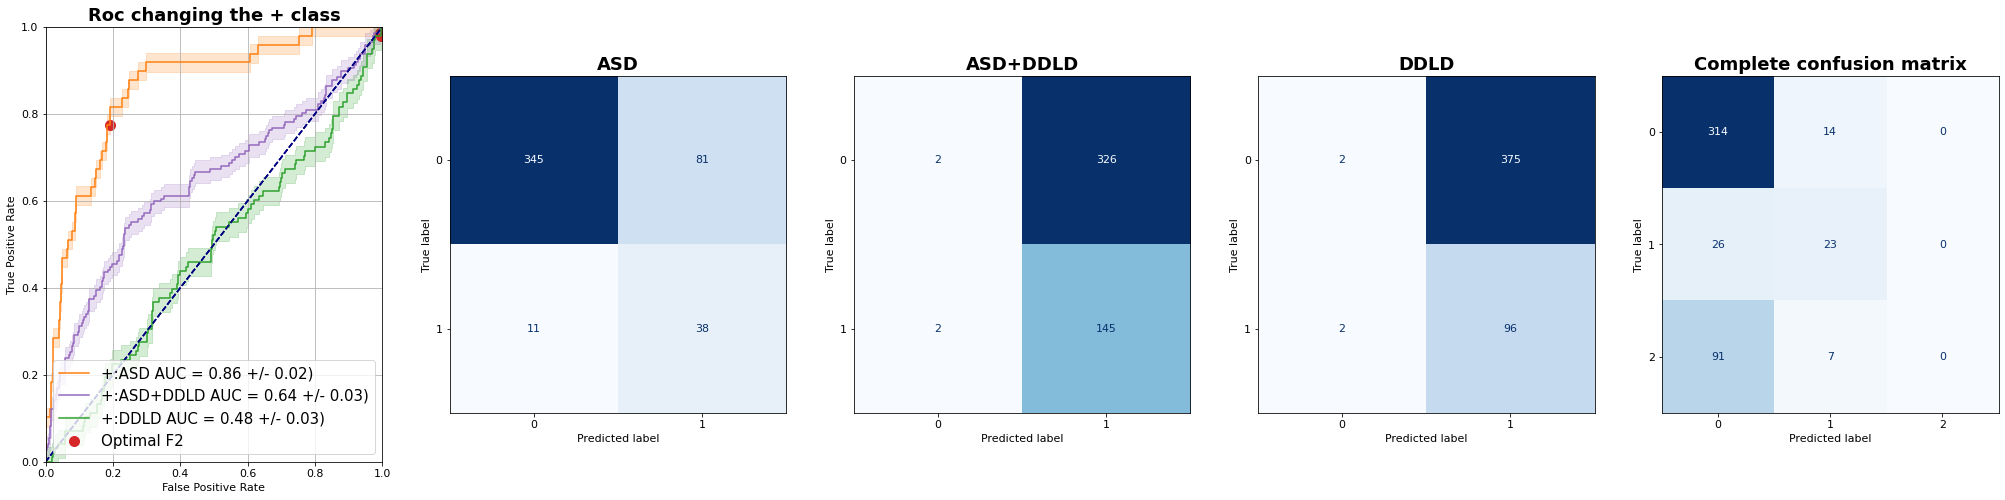

In [82]:
xgboost_hyperparameters = {'scale_pos_weight':False,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular_ddld', 
               #positive_class = [2],
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)
exp.fit_predict(num_cv=10, sample_weight=weighted_confidence_score)
exp.plot()